In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD642/MD642_anchor.txt
File does not exist: 

In [3]:
stack_fixed = 'MD591'
stack_moving = 'atlasV3'

In [4]:
classifier_setting = 30
warp_setting = 1

In [5]:
from pandas import read_hdf, DataFrame, read_csv
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)

In [6]:
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx,std_ty,std_tz,std_theta_xy
warp_id,,,,,,,,,
1,None,affine,0.000010,100000.0,1000,100,100,100,30
7,None,rigid,0.000001,100000.0,1000,50,50,50,10
10,None,rigid,0.000010,100000.0,1000,100,100,100,30


In [7]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx = warp_properties['std_tx']
std_ty = warp_properties['std_ty']
std_tz = warp_properties['std_tz']
std_theta_xy = warp_properties['std_theta_xy']

upstream_warp_id                    None
transform_type                    affine
terminate_thresh                   1e-05
grad_computation_sample_number    100000
grid_search_sample_number           1000
std_tx                               100
std_ty                               100
std_tz                               100
std_theta_xy                          30
Name: 1, dtype: object


In [8]:
# if warp_setting == 1:
#     upstream_warp_setting = None
#     transform_type = 'affine'
    
#     terminate_thresh = 1e-5
#     grad_computation_sample_number = 1e5
#     grid_search_sample_number = 1000
#     std_tx = 100
#     std_ty = 100
#     std_tz = 100
#     std_theta_xy = np.deg2rad(30)

# elif warp_setting == 7:
#     upstream_warp_setting = None
#     transform_type = 'rigid'
    
#     terminate_thresh = 1e-6
#     grad_computation_sample_number = 1e5
#     grid_search_sample_number = 1000
#     std_tx = 50
#     std_ty = 50
#     std_tz = 50
#     std_theta_xy = np.deg2rad(10)
    
# elif warp_setting == 10:
#     upstream_warp_setting = None
#     transform_type = 'rigid'
    
#     terminate_thresh = 1e-5
#     grad_computation_sample_number = 1e5
#     grid_search_sample_number = 1000
#     std_tx = 100
#     std_ty = 100
#     std_tz = 100
#     std_theta_xy = np.deg2rad(30) # important 10 degrees is not enough

# else:
#     raise Exception('Warp setting not recognized.')

In [9]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_score_volume_all_known_structures(stack=stack_moving, sided=True)

print volume_moving[1].shape

File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_annotationVolume/atlasV3_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp


Child returned 0
Child returned 1
0.35 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp
(373, 430, 369)


Child returned 1
0.37 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (373, 430, 369)


In [10]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting, 
                                                   sided=False)

print volume_fixed[1].shape

File does not exist: /shared/CSHL_volumes/MD591/MD591_down32_annotationVolume/MD591_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes/MD591_down32_scoreVolume_clf_30_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes/MD591_down32_scoreVolume_clf_30_outerContour.bp /shared/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes/MD591_down32_scoreVolume_clf_30_outerContour.bp


Child returned 0
Child returned 1
0.36 seconds.
File does not exist: /shared/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes/MD591_down32_scoreVolume_clf_30_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes/MD591_down32_scoreVolume_clf_30_sp5.bp && mkdir -p /shared/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes/MD591_down32_scoreVolume_clf_30_sp5.bp /shared/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes/MD591_down32_scoreVolume_clf_30_sp5.bp
(410, 500, 375)


Child returned 1
0.35 seconds.
File does not exist: /shared/CSHL_volumes/MD591/MD591_down32_scoreVolume_clf_30/score_volumes/MD591_down32_scoreVolume_clf_30_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (410, 500, 375)


In [11]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in ['7N_L', '7N_R', '12N', '5N_L', 'Pn_R', 'SNR_L', 
                                   'VLL_R', '7n_L', 'Tz_R', 'VCA_L', 'VCP_R']}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [12]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [13]:
# structures_sorted_by_size = [x[1] for x in sorted((s, label_to_structure_moving[l]) for l, s in volume_moving_structure_sizes.iteritems())]
# print structures_sorted_by_size

In [14]:
label_weights_m = {}
for label_m, name_m in label_to_structure_moving.iteritems():
    if 'surround' in name_m:
        label_weights_m[label_m] = 0
    else:
        label_weights_m[label_m] = 1
#         label_weights_m[label_m] = np.minimum(1e5 / volume_moving_structure_sizes[label_m], 1.)

# Compute Registration

In [15]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [16]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

m: [ 215.   186.5  184.5] f: [ 215.   186.5  184.5]


In [17]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
                                                          classifier_setting=classifier_setting)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [18]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins

set([2, 5, 7, 8, 16, 21, 25, 26, 27, 28])


load gradient 2: 4.932364 seconds
load gradient 5: 3.916975 seconds
load gradient 7: 5.233507 seconds
load gradient 8: 3.553581 seconds
load gradient 16: 3.030096 seconds
load gradient 21: 7.119639 seconds
load gradient 25: 7.251388 seconds
load gradient 26: 9.516915 seconds
load gradient 27: 6.542807 seconds
load gradient 28: 6.978433 seconds
overall: 58.076689 seconds


In [19]:
aligner.set_label_weights(label_weights=label_weights_m)

In [20]:
# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

# while True:

T_all_trials = []
scores_all_trials = []

for _ in range(5):

    try:
        T, scores = aligner.optimize(type=transform_type, max_iter_num=1000, history_len=10, 
                                     terminate_thresh=terminate_thresh,
                                     grid_search_iteration_number=30,
                                     grid_search_sample_number=grid_search_sample_number,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=10, lr2=0.1,
                                     std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=std_theta_xy)
                
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


grid search: 5.941130 seconds
tx_best: -32.03 (voxel), ty_best: -39.30, tz_best: -33.06, theta_xy_best: 346.80 (deg)
sigma_tx: 100.00 (voxel), sigma_ty: 100.00, sigma_tz: 100.00, sigma_theta_xy: 1718.87 (deg)
-inf 0.211435
grid search: 4.134154 seconds
tx_best: -6.87 (voxel), ty_best: -20.40, tz_best: -9.44, theta_xy_best: 731.05 (deg)
sigma_tx: 71.65 (voxel), sigma_ty: 71.65, sigma_tz: 71.65, sigma_theta_xy: 1231.63 (deg)
0.211435 0.225975
grid search: 3.229566 seconds
tx_best: -6.87 (voxel), ty_best: -20.40, tz_best: -9.44, theta_xy_best: 731.05 (deg)
sigma_tx: 51.34 (voxel), sigma_ty: 51.34, sigma_tz: 51.34, sigma_theta_xy: 882.50 (deg)
grid search: 2.626292 seconds
tx_best: -6.90 (voxel), ty_best: -20.18, tz_best: -24.06, theta_xy_best: 731.79 (deg)
sigma_tx: 36.79 (voxel), sigma_ty: 36.79, sigma_tz: 36.79, sigma_theta_xy: 632.34 (deg)
0.225975 0.227145
grid search: 1.927767 seconds
tx_best: -25.05 (voxel), ty_best: -27.78, tz_best: -21.26, theta_xy_best: 1072.20 (deg)
sigma_tx: 26

params_best_upToNow [-25.05121916 -27.78402041 -21.26083773  18.713337  ]


step: 0.24 seconds
score: 0.232575
iteration 1
step: 0.25 seconds
score: 0.187365
iteration 2
step: 0.24 seconds
score: 0.242828
iteration 3
step: 0.25 seconds
score: 0.275693
iteration 4
step: 0.23 seconds
score: 0.242660
iteration 5
step: 0.25 seconds
score: 0.270825
iteration 6
step: 0.25 seconds
score: 0.277695
iteration 7
step: 0.24 seconds
score: 0.276267
iteration 8
step: 0.25 seconds
score: 0.277931
iteration 9
step: 0.25 seconds
score: 0.287405
iteration 10
step: 0.25 seconds
score: 0.286798
iteration 11
step: 0.25 seconds
score: 0.283893
iteration 12
step: 0.25 seconds
score: 0.276718
iteration 13
step: 0.25 seconds
score: 0.278772
iteration 14
step: 0.25 seconds
score: 0.277633
iteration 15
step: 0.25 seconds
score: 0.282951
iteration 16
step: 0.25 seconds
score: 0.281150
iteration 17
step: 0.25 seconds
score: 0.286171
iteration 18
step: 0.25 seconds
score: 0.288847
iteration 19
step: 0.25 seconds
score: 0.288133
iteration 20
step: 0.25 seconds
score: 0.288090
iteration 21
s

params_best_upToNow [-23.89954895 -43.51707614 -17.73303051   6.25082029]


step: 0.24 seconds
score: 0.233149
iteration 1
step: 0.25 seconds
score: 0.169708
iteration 2
step: 0.25 seconds
score: 0.183087
iteration 3
step: 0.25 seconds
score: 0.212905
iteration 4
step: 0.23 seconds
score: 0.248523
iteration 5
step: 0.25 seconds
score: 0.247120
iteration 6
step: 0.24 seconds
score: 0.247000
iteration 7
step: 0.25 seconds
score: 0.277517
iteration 8
step: 0.25 seconds
score: 0.266210
iteration 9
step: 0.25 seconds
score: 0.277720
iteration 10
step: 0.25 seconds
score: 0.282012
iteration 11
step: 0.25 seconds
score: 0.278835
iteration 12
step: 0.25 seconds
score: 0.270811
iteration 13
step: 0.25 seconds
score: 0.283426
iteration 14
step: 0.25 seconds
score: 0.284181
iteration 15
step: 0.25 seconds
score: 0.282676
iteration 16
step: 0.25 seconds
score: 0.281378
iteration 17
step: 0.25 seconds
score: 0.285552
iteration 18
step: 0.25 seconds
score: 0.286924
iteration 19
step: 0.25 seconds
score: 0.286161
iteration 20
step: 0.25 seconds
score: 0.287446
iteration 21
s

params_best_upToNow [ 28.06549482  39.88634686  -3.90573589  18.76273813]


step: 0.27 seconds
score: 0.283148
iteration 1
step: 0.25 seconds
score: 0.287648
iteration 2
step: 0.25 seconds
score: 0.250964
iteration 3
step: 0.26 seconds
score: 0.294442
iteration 4
step: 0.25 seconds
score: 0.269999
iteration 5
step: 0.26 seconds
score: 0.247626
iteration 6
step: 0.25 seconds
score: 0.329268
iteration 7
step: 0.26 seconds
score: 0.262346
iteration 8
step: 0.25 seconds
score: 0.325352
iteration 9
step: 0.25 seconds
score: 0.351260
iteration 10
step: 0.26 seconds
score: 0.325418
iteration 11
step: 0.25 seconds
score: 0.314821
iteration 12
step: 0.26 seconds
score: 0.319138
iteration 13
step: 0.25 seconds
score: 0.352822
iteration 14
step: 0.26 seconds
score: 0.331442
iteration 15
step: 0.26 seconds
score: 0.371295
iteration 16
step: 0.26 seconds
score: 0.351166
iteration 17
step: 0.25 seconds
score: 0.360400
iteration 18
step: 0.26 seconds
score: 0.359375
iteration 19
step: 0.26 seconds
score: 0.355037
iteration 20
step: 0.26 seconds
score: 0.375969
iteration 21
s

params_best_upToNow [ 45.52419631  36.98382705  -1.35699234  12.53171657]


step: 0.26 seconds
score: 0.310229
iteration 1
step: 0.26 seconds
score: 0.195458
iteration 2
step: 0.25 seconds
score: 0.231668
iteration 3
step: 0.25 seconds
score: 0.288532
iteration 4
step: 0.25 seconds
score: 0.252156
iteration 5
step: 0.25 seconds
score: 0.278190
iteration 6
step: 0.25 seconds
score: 0.257018
iteration 7
step: 0.25 seconds
score: 0.338414
iteration 8
step: 0.25 seconds
score: 0.278636
iteration 9
step: 0.25 seconds
score: 0.348292
iteration 10
step: 0.25 seconds
score: 0.323381
iteration 11
step: 0.25 seconds
score: 0.306107
iteration 12
step: 0.25 seconds
score: 0.308938
iteration 13
step: 0.25 seconds
score: 0.358204
iteration 14
step: 0.25 seconds
score: 0.335906
iteration 15
step: 0.25 seconds
score: 0.340495
iteration 16
step: 0.25 seconds
score: 0.321849
iteration 17
step: 0.25 seconds
score: 0.367349
iteration 18
step: 0.25 seconds
score: 0.354423
iteration 19
step: 0.25 seconds
score: 0.348310
iteration 20
step: 0.25 seconds
score: 0.357140
iteration 21
s

step: 0.25 seconds
score: 0.414923
iteration 171
step: 0.25 seconds
score: 0.414653
iteration 172
step: 0.25 seconds
score: 0.414890
iteration 173
step: 0.25 seconds
score: 0.414680
grid search: 5.946612 seconds
tx_best: -15.84 (voxel), ty_best: -64.15, tz_best: -26.51, theta_xy_best: 349.03 (deg)
sigma_tx: 100.00 (voxel), sigma_ty: 100.00, sigma_tz: 100.00, sigma_theta_xy: 1718.87 (deg)
-inf 0.209808
grid search: 4.485511 seconds
tx_best: -20.74 (voxel), ty_best: -50.97, tz_best: -9.75, theta_xy_best: 360.53 (deg)
sigma_tx: 71.65 (voxel), sigma_ty: 71.65, sigma_tz: 71.65, sigma_theta_xy: 1231.63 (deg)
0.209808 0.232268
grid search: 3.047212 seconds
tx_best: -20.74 (voxel), ty_best: -50.97, tz_best: -9.75, theta_xy_best: 360.53 (deg)
sigma_tx: 51.34 (voxel), sigma_ty: 51.34, sigma_tz: 51.34, sigma_theta_xy: 882.50 (deg)
grid search: 2.436360 seconds
tx_best: -20.74 (voxel), ty_best: -50.97, tz_best: -9.75, theta_xy_best: 360.53 (deg)
sigma_tx: 36.79 (voxel), sigma_ty: 36.79, sigma_tz: 

params_best_upToNow [-20.73759892 -50.9744691   -9.74697115   6.29249784]


step: 0.25 seconds
score: 0.232268
iteration 1
step: 0.25 seconds
score: 0.245302
iteration 2
step: 0.23 seconds
score: 0.219938
iteration 3
step: 0.25 seconds
score: 0.255823
iteration 4
step: 0.25 seconds
score: 0.278264
iteration 5
step: 0.25 seconds
score: 0.271622
iteration 6
step: 0.24 seconds
score: 0.265982
iteration 7
step: 0.25 seconds
score: 0.282524
iteration 8
step: 0.25 seconds
score: 0.282221
iteration 9
step: 0.25 seconds
score: 0.273778
iteration 10
step: 0.25 seconds
score: 0.273195
iteration 11
step: 0.24 seconds
score: 0.269370
iteration 12
step: 0.25 seconds
score: 0.282476
iteration 13
step: 0.25 seconds
score: 0.280010
iteration 14
step: 0.25 seconds
score: 0.286087
iteration 15
step: 0.25 seconds
score: 0.282145
iteration 16
step: 0.25 seconds
score: 0.285529
iteration 17
step: 0.25 seconds
score: 0.283934
iteration 18
step: 0.25 seconds
score: 0.288759
iteration 19
step: 0.25 seconds
score: 0.286646
iteration 20
step: 0.25 seconds
score: 0.284513
iteration 21
s

In [40]:
# plt.plot(np.arange(30), std_tx*np.exp(-np.arange(30)/3.));
# plt.xlabel('Iteration');
# plt.ylabel('Search radius (voxel)');
# plt.title('Grid search radius shrinking schedule');
# plt.show();

File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD642/MD642_anchor.txt
File does not exist: /shared

Widest standard deviation of converged translation parameters for different trials: 19.50 voxels, 286.98 um


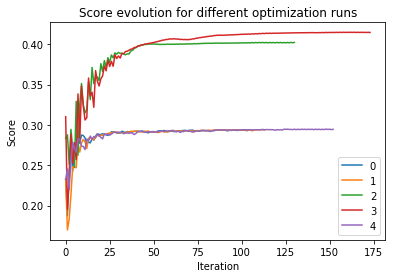

In [43]:
converged_scores = np.array([s[-1] for s in scores_all_trials])
q3 = np.percentile(converged_scores, 75)
q1 = np.percentile(converged_scores, 25)
iqr = q3 - q1
inlier_min = q1 - 1.5 * iqr
inlier_max = q3 + 1.5 * iqr
inliers = np.where((converged_scores > inlier_min) & (converged_scores < inlier_max))[0]

plt.figure();
for trial_idx, scores in enumerate(scores_all_trials):
    plt.plot(scores, label=trial_idx);
plt.xlabel('Iteration');
plt.ylabel('Score');
plt.legend();
plt.title('Score evolution for different optimization runs');

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
T_all_trials = np.array(T_all_trials)
t_std = np.std(pca.fit_transform(T_all_trials[inliers[:,None] ,[3,7,11]])[0])
t_std_um = t_std * XY_PIXEL_DISTANCE_TB
print 'Widest standard deviation of converged translation parameters for different trials: %.2f voxels, %.2f um' % (t_std, t_std_um)

# tx_std = np.std(T_all_trials[inliers, 3])
# ty_std = np.std(T_all_trials[inliers, 7])
# tz_std = np.std(T_all_trials[inliers, 11])
# tx_std_um = tx_std * XY_PIXEL_DISTANCE_TB
# ty_std_um = ty_std * XY_PIXEL_DISTANCE_TB
# tz_std_um = tz_std * XY_PIXEL_DISTANCE_TB
# print 'tx std:', tx_std, 'voxels', tx_std_um, 'um'
# print 'ty std:', ty_std, 'voxels', ty_std_um, 'um'
# print 'tz std:', tz_std, 'voxels', tz_std_um, 'um'

# plt.scatter(np.ones((5,)), np.array(T_all_trials)[:, 3], marker='+');
# plt.scatter(2*np.ones((5,)), np.array(T_all_trials)[:, 7], marker='+');
# plt.scatter(3*np.ones((5,)), np.array(T_all_trials)[:, 11], marker='+');

[[  8.93033988e-01   1.98109853e-01  -2.23220627e-02  -4.33675435e+01]
 [ -7.30805816e-02   7.90781830e-01  -2.03855778e-01  -2.50405491e+01]
 [ -2.12566550e-02   1.08399192e-01   8.69527840e-01  -2.91481467e+01]]
0.294852541527 0.294546414167


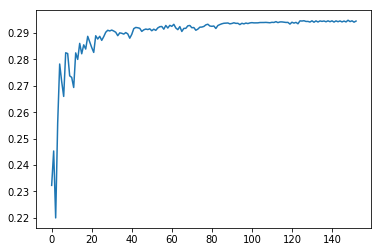

In [32]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

# Export parameters and score plots

In [33]:
for trial_idx in range(5):
    
    T = T_all_trials[trial_idx]
    scores = scores_all_trials[trial_idx]
    
    params_fp = \
    DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                  classifier_setting_m=classifier_setting,
                                                  classifier_setting_f=classifier_setting,
                                                  warp_setting=warp_setting,
                                                  trial_idx=trial_idx)

    DataManager.save_alignment_parameters(params_fp, T, 
                                          aligner.centroid_m, aligner.centroid_f,
                                          aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                          aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

    upload_from_ec2_to_s3(params_fp)

    score_plot_fp = \
    DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                         classifier_setting_m=classifier_setting,
                                                         classifier_setting_f=classifier_setting,
                                                         warp_setting=warp_setting,
                                                         trial_idx=trial_idx)
    fig = plt.figure();
    plt.plot(scores);
    plt.savefig(score_plot_fp, bbox_inches='tight')
    plt.close(fig)

    upload_from_ec2_to_s3(score_plot_fp)

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_0_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_0_parameters.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_1_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_1_parameters.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_1_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_1_scoreEvolution.png


Child returned 0
0.58 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_2_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_2_parameters.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_2_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_2_scoreEvolution.png


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_3_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_3_parameters.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_3_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_3_scoreEvolution.png


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_4_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_4_parameters.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_4_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD591_down32_scoreVolume_clf_30_trial_4_scoreEvolution.png


Child returned 0
0.43 seconds.


# Draw Results

In [34]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [36]:
# # Transform moving volume, sided, without surround

# structure = '5N_L'

# vol_m = DataManager.load_volume(stack=stack_moving, structure=structure, downscale=32)

# volume_m_alignedTo_f = \
# transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
#                   xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

In [37]:
# # Set colors for different contour level
# levels = [0.1, 0.25, 0.5, 0.75, .99]
# level_colors = {level: (int(level*255),0,0) for level in levels}

In [42]:
# # Generate overlay visualization

# # For getting correct contour location

# # xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
# # DataManager.load_volume_bbox(stack=stack_fixed, type='score', structure='7N', 
# #                              downscale=32, classifier_setting=classifier_setting)
# # print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f = DataManager.load_cropbox(stack=stack_fixed)[:4]

# # Generate atlas overlay image for every section

# zf, zl = bbox_3d(volume_m_alignedTo_f)[4:]
# sec_first = DataManager.convert_z_to_section(stack=stack_fixed, z=zf, downsample=32)
# sec_last = DataManager.convert_z_to_section(stack=stack_fixed, z=zl, downsample=32)

# for sec in range(sec_first, sec_last+1):
# # for sec in [155]:
    
#     if is_invalid(metadata_cache['sections_to_filenames'][stack_fixed][sec]):
#         continue
    
#     try:
#         img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
#         img = imread(img_fn)
# #         img = imread(DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, 
# #                                                            downscale=32,
# #                                                            structure=convert_to_original_name(structure), 
# #                                                            setting=classifier_setting))
#     except:
#         sys.stderr.write('Error loading scoremap for section %d\n' % sec)
#         continue
    
#     viz = img.copy()
    
#     z1, z2 = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
#     z = int(z1)
    
#     # Find moving volume annotation contours
#     c = 0
#     vol = volume_m_alignedTo_f
#     for level in levels:
#         cnts = find_contours(vol[..., z], level=level) # rows, cols
#         c += len(cnts)
#         for cnt in cnts:
#             # r,c to x,y
#             cnt_on_cropped = cnt[:, ::-1] + (xmin_vol_f, ymin_vol_f)
#             cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 1)
    
#     if c > 0:    
# #         plt.figure(figsize=(20,20));
#         plt.figure();
#         plt.title("sec=%d, z=%d, c=%d" % (sec, z, c));
#         plt.imshow(viz);
#         plt.show();


Error loading scoremap for section 143
Error loading scoremap for section 144
Error loading scoremap for section 145
Error loading scoremap for section 146
Error loading scoremap for section 147
Error loading scoremap for section 148
Error loading scoremap for section 149
Error loading scoremap for section 150
Error loading scoremap for section 151
Error loading scoremap for section 152
Error loading scoremap for section 153
Error loading scoremap for section 154
Error loading scoremap for section 155
Error loading scoremap for section 156
Error loading scoremap for section 157
Error loading scoremap for section 158
Error loading scoremap for section 159
Error loading scoremap for section 160
Error loading scoremap for section 161
Error loading scoremap for section 162
Error loading scoremap for section 163
Error loading scoremap for section 164
Error loading scoremap for section 165
Error loading scoremap for section 166
Error loading scoremap for section 167
Error loading scoremap fo